In [1]:
from visualizer import calibration
import visual

from PyQt5 import QtCore
import tifffile
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import zarr
from skimage.registration import phase_cross_correlation
import cv2 as cv
from skimage import io

import cupy as cp 
import waveorder as wo
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask

import cv2 as cv
%gui qt 
%matplotlib inline
plt.style.use('dark_background')


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
viewer = napari.Viewer()

In [3]:
### Enter the filepath for the data directory
main_dir =r'F:\Test_ignore\20220509_M25_oh15265_23'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_pcc = os.path.join(offset_dir,"offsets_pcc.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

if os.path.exists(offsets_file_pcc):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets_pcc = np.loadtxt(file_name, delimiter=",")
## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

loading offsets
loading offsets


In [4]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

In [18]:
filename = 'MIP.tif'
# filename = '220508_380nmSteps_minusplus_reversed_1_MMStack_Pos0.ome.tif'
psf_file = os.path.join(offset_dir,filename)
np_mip = tifffile.imread(psf_file)
np_mip_8bit =visual.im_bit_convert(np_mip,bit=8,norm=True)

In [19]:
viewer.add_image(np_mip_8bit)

<Image layer 'np_mip_8bit' at 0x1f705513c10>

In [20]:
sift = cv.SIFT_create()
kp = sift.detect(np_mip_8bit[13],None)
img1= cv.drawKeypoints(np_mip_8bit[13],kp,np_mip_8bit[13],flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [21]:
img1 = np.swapaxes(img1,0,2)

In [22]:
viewer.add_image(img1)

<Image layer 'img1' at 0x1f705513a30>

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1f7146f86d0>)

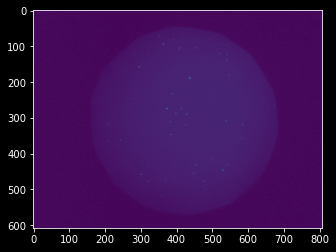

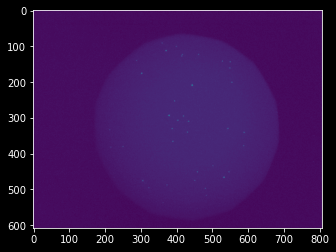

In [70]:
img1 = np_mip_8bit[11]
img2 = np_mip_8bit[13]
# img1 = cv.imread(r'F:\Test_ignore\sift_test\t1.jpg')
# img2 = cv.imread(r'F:\Test_ignore\sift_test\t2.jpg')
# img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
# img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
plt.figure(),plt.imshow(img1)
plt.figure(),plt.imshow(img2)

In [73]:
# Initiate SIFT detector
orb = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
# kp1, des1 = orb.detectAndCompute(img1,None)
# kp2, des2 = orb.detectAndCompute(img2,None)
kp1 = orb.detect(img1,None)
kp2 = orb.detect(img2,None)

img=cv.drawKeypoints(img1 ,
                      kp1 ,
                      img1,
                      flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(kp1))
print(len(kp2))

0
0


In [72]:
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

        # cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,img2,flags=2)
plt.imshow(img3),plt.show()
viewer.add_image(img3)


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\features2d\src\draw.cpp:241: error: (-215:Assertion failed) i1 >= 0 && i1 < static_cast<int>(keypoints1.size()) in function 'cv::drawMatches'
